In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data_dir = '/content/drive/MyDrive/kaggle competitions/intel-image-classification'
os.listdir(data_dir)

['intel-image-classification.zip',
 'seg_pred',
 'seg_test',
 'seg_train',
 'intel_image_classification.pth']

In [ ]:
os.listdir(os.path.join(data_dir, 'seg_train/seg_train'))

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
os.listdir(os.path.join(data_dir, 'seg_test/seg_test'))

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
train_folder = os.path.join(data_dir, 'seg_train/seg_train')
test_folder = os.path.join(data_dir, 'seg_test/seg_test')

In [ ]:
for cls in os.listdir(train_folder):
  print(f'There are [{len(os.listdir(os.path.join(train_folder, cls)))}] images of [{cls}] class in train dataset and\n\
  \t [{len(os.listdir(os.path.join(test_folder, cls)))}] images in the test dataset')

There are [2191] images of [buildings] class in train dataset and
  	 [437] images in the test dataset
There are [2271] images of [forest] class in train dataset and
  	 [474] images in the test dataset
There are [2404] images of [glacier] class in train dataset and
  	 [553] images in the test dataset
There are [2512] images of [mountain] class in train dataset and
  	 [525] images in the test dataset
There are [2274] images of [sea] class in train dataset and
  	 [510] images in the test dataset
There are [2382] images of [street] class in train dataset and
  	 [501] images in the test dataset


In [ ]:
train_stats = ((0.4302, 0.4575, 0.4539), (0.2290, 0.2278, 0.2402))
test_stats = ((0.4332, 0.4586, 0.4552), (0.2303, 0.2285, 0.2410))
train_tfms = tt.Compose([tt.Resize([128, 128]),
                         tt.RandomCrop(128, padding=16, padding_mode='reflect'),
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.Normalize(*train_stats)])
test_tfms = tt.Compose([tt.Resize([128, 128]), tt.ToTensor(), tt.Normalize(*test_stats)])

In [ ]:
train_data = ImageFolder(train_folder, transform=train_tfms)
test_data = ImageFolder(test_folder, transform=test_tfms)

In [ ]:
len(train_data), len(test_data)

(14034, 3000)

In [ ]:
val_size = 4034
train_size = len(train_data) - val_size

train_ds, val_ds = random_split(train_data, [train_size, val_size])
len(train_ds), len(val_ds)

(10000, 4034)

In [ ]:
batch_size = 100
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_data, batch_size*2, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 128, 128])


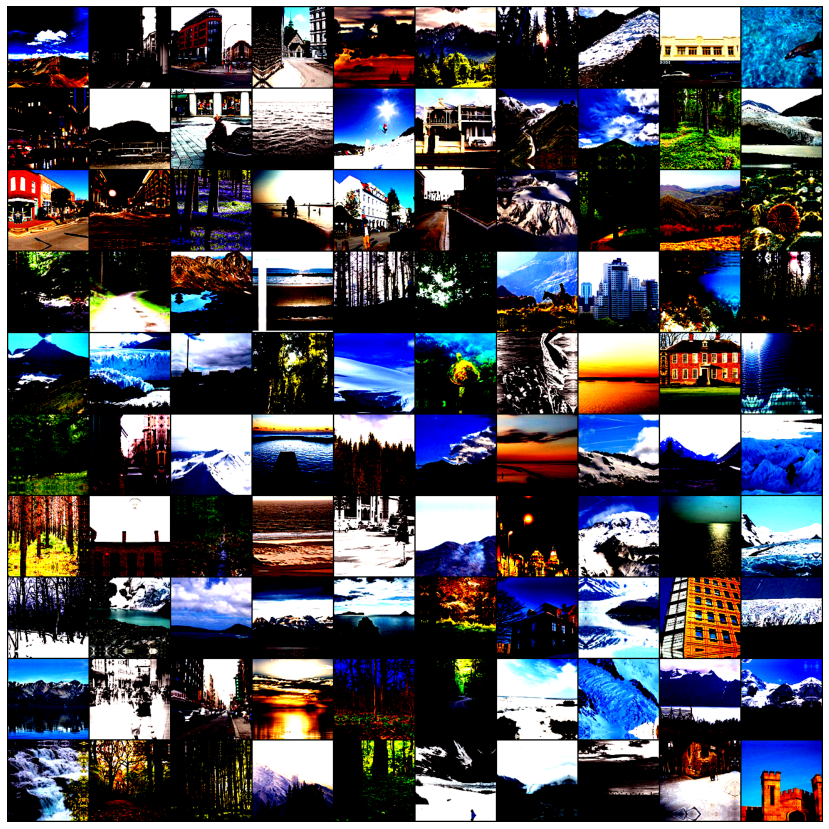

In [ ]:
for img, _ in train_dl:
  print(img.shape)
  plt.figure(figsize=(15, 15))
  plt.axis('off')
  plt.imshow(make_grid(img, nrow=10).permute(1, 2, 0))
  break

In [ ]:
# nimages = 0
# mean = 0.0
# var = 0.0
# for i_batch, batch_target in enumerate(test_dl):
#     batch = batch_target[0]
#     # Rearrange batch to be the shape of [B, C, W * H]
#     batch = batch.view(batch.size(0), batch.size(1), -1)
#     # Update total number of images
#     nimages += batch.size(0)
#     # Compute mean and std here
#     mean += batch.mean(2).sum(0)
#     var += batch.var(2).sum(0)

# mean /= nimages
# var /= nimages
# std = torch.sqrt(var)

# print(mean)
# print(std)

In [ ]:
def accuracy(out, targets):
  _, preds = torch.max(out, dim=1)
  return torch.tensor(torch.sum(preds == targets).item() / len(preds))

In [ ]:
class ClassificationBase(nn.Module):
  def training_step(self, batch):
    xb, targets = batch
    out = self(xb)
    loss = F.cross_entropy(out, targets)
    return loss
  def validation_step(self, batch):
    xb, targets = batch
    out = self(xb)
    loss = F.cross_entropy(out, targets)
    acc = accuracy(out, targets)
    return {'loss': loss, 'acc': acc}
  def validation_epoch_end(self, res):
    losses = [x['loss'] for x in res]
    loss = torch.stack(losses).mean()
    accs = [x['acc'] for x in res]
    acc = torch.stack(accs).mean()
    return {'loss': loss.item(), 'acc': acc.item()}
  def epoch_end(self, epoch, res):
    print(f'Epoch: [{epoch}], Train loss: [{round(res["train_loss"], 4)}], Last lr: [{res["lrs"][-1]}],\
    Validation loss: [{round(res["loss"], 4)}], Validation accuracy: [{round(res["acc"], 4)}] %.')

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device
  def __iter__(self):
    for b in self.dl: yield to_device(b, self.device)
  def __len__(self):
    return len(self.dl)

In [ ]:
def conv_block(in_channels: int, out_channels: int, pool: bool=False):
  layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)]
  if pool: layers.append(nn.MaxPool2d(2))
  return nn.Sequential(*layers)

In [ ]:
@torch.no_grad()
def evaluate(model, dl):
  model.eval()
  res = [model.validation_step(batch) for batch in dl]
  return model.validation_epoch_end(res)

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def fit_one_cycle(n_epochs, model, train_dl, val_dl, max_lr,
                  weight_decay=0, grad_clip=None, opt_f=torch.optim.SGD):
  history = []
  optimizer = opt_f(model.parameters(), max_lr, weight_decay=weight_decay)
  sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=n_epochs,
                                              steps_per_epoch=len(train_dl))

  for epoch in range(n_epochs):
    model.train()
    train_losses = []
    lrs = []
    for batch in train_dl:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()

      if grad_clip:
        nn.utils.clip_grad_value_(model.parameters(), grad_clip)

      optimizer.step()
      optimizer.zero_grad()
      lrs.append(get_lr(optimizer))
      sched.step()
    res = evaluate(model, val_dl)
    res['train_loss'] = torch.stack(train_losses).mean().item()
    res['lrs'] = lrs
    history.append(res)
    model.epoch_end(epoch, res)
  return history

#Model 1 - ResNet 10 layers

In [ ]:
class ResNet(ClassificationBase):
  def __init__(self, in_channels: int=3, n_classes: int=6):
    super().__init__()
    self.conv1 = conv_block(in_channels, 32) # 32 x 128 x 128
    self.conv2 = conv_block(32, 64, pool=True) # 64 x 64 x 64
    self.res1 = nn.Sequential(conv_block(64, 64), conv_block(64, 64)) # 64 x 64 x 64

    self.conv3 = conv_block(64, 128, pool=True) # 128 x 32 x 32
    self.conv4 = conv_block(128, 256, pool=True) # 256 x 16 x 16
    self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))

    self.conv5 = conv_block(256, 512, pool=True) # 512 x 8 x 8
    self.conv6 = conv_block(512, 1024, pool=True) # 1024 x 4 x 4
    self.res3 = nn.Sequential(conv_block(1024, 1024), conv_block(1024, 1024))

    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Linear(1024, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, n_classes))
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out

    out = self.conv5(out)
    out = self.conv6(out)
    out = self.res3(out) + out

    out = self.classifier(out)
    return out

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
model1 = to_device(ResNet(), device)
model1

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

In [ ]:
hitory1 = [evaluate(model1, val_dl)]

In [ ]:
hitory1

[{'acc': 0.1762325018644333, 'loss': 1.7926679849624634}]

In [ ]:
n_epochs = 10
max_lr = 0.1
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
hitory1 += fit_one_cycle(n_epochs, model1, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [1.1882], Last lr: [0.027709412669592093],    Validation loss: [1.0806], Validation accuracy: [0.5301] %.
Epoch: [1], Train loss: [1.4283], Last lr: [0.07585426385513103],    Validation loss: [102.0756], Validation accuracy: [0.1596] %.
Epoch: [2], Train loss: [2.0554], Last lr: [0.1],    Validation loss: [202.3923], Validation accuracy: [0.1596] %.
Epoch: [3], Train loss: [1.6961], Last lr: [0.09504846320134738],    Validation loss: [1.8504], Validation accuracy: [0.2965] %.
Epoch: [4], Train loss: [1.3216], Last lr: [0.0811745653949763],    Validation loss: [1.9362], Validation accuracy: [0.2212] %.
Epoch: [5], Train loss: [1.2344], Last lr: [0.06112620219362893],    Validation loss: [2.1646], Validation accuracy: [0.2463] %.
Epoch: [6], Train loss: [1.2112], Last lr: [0.03887419780637107],    Validation loss: [1.3356], Validation accuracy: [0.3496] %.
Epoch: [7], Train loss: [1.1494], Last lr: [0.0188258346050237],    Validation loss: [1.1901], Validation acc

In [ ]:
n_epochs = 10
max_lr = 0.03
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
hitory1 += fit_one_cycle(n_epochs, model1, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.9104], Last lr: [0.008312823800877625],    Validation loss: [0.9267], Validation accuracy: [0.6161] %.
Epoch: [1], Train loss: [0.8613], Last lr: [0.022756279156539303],    Validation loss: [1.5151], Validation accuracy: [0.4849] %.
Epoch: [2], Train loss: [0.8888], Last lr: [0.03],    Validation loss: [3.1931], Validation accuracy: [0.1854] %.
Epoch: [3], Train loss: [0.8709], Last lr: [0.02851453896040421],    Validation loss: [1.334], Validation accuracy: [0.5322] %.
Epoch: [4], Train loss: [0.8083], Last lr: [0.02435236961849289],    Validation loss: [2.7278], Validation accuracy: [0.4079] %.
Epoch: [5], Train loss: [0.7871], Last lr: [0.01833786065808868],    Validation loss: [1.059], Validation accuracy: [0.5535] %.
Epoch: [6], Train loss: [0.7314], Last lr: [0.011662259341911322],    Validation loss: [0.7498], Validation accuracy: [0.7044] %.
Epoch: [7], Train loss: [0.6824], Last lr: [0.00564775038150711],    Validation loss: [0.6894], Validation accu

In [ ]:
n_epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
hitory1 += fit_one_cycle(n_epochs, model1, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.5804], Last lr: [0.002770941266959208],    Validation loss: [0.5868], Validation accuracy: [0.7833] %.
Epoch: [1], Train loss: [0.5812], Last lr: [0.007585426385513102],    Validation loss: [1.0245], Validation accuracy: [0.6517] %.
Epoch: [2], Train loss: [0.6091], Last lr: [0.01],    Validation loss: [0.6941], Validation accuracy: [0.7431] %.
Epoch: [3], Train loss: [0.5892], Last lr: [0.009504846320134737],    Validation loss: [0.7135], Validation accuracy: [0.7375] %.
Epoch: [4], Train loss: [0.5653], Last lr: [0.008117456539497631],    Validation loss: [0.5807], Validation accuracy: [0.7926] %.
Epoch: [5], Train loss: [0.5517], Last lr: [0.0061126202193628925],    Validation loss: [0.5456], Validation accuracy: [0.8035] %.
Epoch: [6], Train loss: [0.5162], Last lr: [0.003887419780637108],    Validation loss: [0.5962], Validation accuracy: [0.7776] %.
Epoch: [7], Train loss: [0.497], Last lr: [0.00188258346050237],    Validation loss: [0.4917], Validation

In [ ]:
n_epochs = 10
max_lr = 0.005
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
hitory1 += fit_one_cycle(n_epochs, model1, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.4542], Last lr: [0.001385470633479604],    Validation loss: [0.4838], Validation accuracy: [0.8214] %.
Epoch: [1], Train loss: [0.4631], Last lr: [0.003792713192756551],    Validation loss: [0.7424], Validation accuracy: [0.7576] %.
Epoch: [2], Train loss: [0.4981], Last lr: [0.005],    Validation loss: [0.7297], Validation accuracy: [0.7345] %.
Epoch: [3], Train loss: [0.4943], Last lr: [0.004752423160067369],    Validation loss: [0.5506], Validation accuracy: [0.8023] %.
Epoch: [4], Train loss: [0.477], Last lr: [0.0040587282697488155],    Validation loss: [0.6184], Validation accuracy: [0.77] %.
Epoch: [5], Train loss: [0.4705], Last lr: [0.0030563101096814462],    Validation loss: [0.4939], Validation accuracy: [0.8153] %.
Epoch: [6], Train loss: [0.46], Last lr: [0.001943709890318554],    Validation loss: [0.463], Validation accuracy: [0.8323] %.
Epoch: [7], Train loss: [0.4284], Last lr: [0.000941291730251185],    Validation loss: [0.4512], Validation a

In [ ]:
n_epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
hitory1 += fit_one_cycle(n_epochs, model1, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.3982], Last lr: [0.00027709412669592087],    Validation loss: [0.4355], Validation accuracy: [0.8459] %.
Epoch: [1], Train loss: [0.4107], Last lr: [0.0007585426385513102],    Validation loss: [0.446], Validation accuracy: [0.8374] %.
Epoch: [2], Train loss: [0.4177], Last lr: [0.001],    Validation loss: [0.4811], Validation accuracy: [0.8267] %.
Epoch: [3], Train loss: [0.4182], Last lr: [0.0009504846320134736],    Validation loss: [0.4535], Validation accuracy: [0.8323] %.
Epoch: [4], Train loss: [0.4103], Last lr: [0.000811745653949763],    Validation loss: [0.4562], Validation accuracy: [0.8348] %.
Epoch: [5], Train loss: [0.4052], Last lr: [0.0006112620219362892],    Validation loss: [0.4445], Validation accuracy: [0.8419] %.
Epoch: [6], Train loss: [0.3982], Last lr: [0.00038874197806371076],    Validation loss: [0.4322], Validation accuracy: [0.8428] %.
Epoch: [7], Train loss: [0.3945], Last lr: [0.00018825834605023698],    Validation loss: [0.4284], 

#Model 2

In [ ]:
class ResNet2(ClassificationBase):
  def __init__(self, in_channels: int=3, n_classes: int=6):
    super().__init__()
    self.conv1 = conv_block(in_channels, 16) # 16 x 128 x 128
    self.conv2 = conv_block(16, 32, pool=True) # 32 x 64 x 64
    self.res1 = nn.Sequential(conv_block(32, 32), conv_block(32, 32))

    self.conv3 = conv_block(32, 64, pool=True) # 64 x 32 x 32
    self.conv4 = conv_block(64, 128, pool=True) # 128 x 16 x 16
    self.res2 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

    self.conv5 = conv_block(128, 256, pool=True) # 256 x 8 x 8
    self.conv6 = conv_block(256, 512, pool=True) # 512 x 4 x 4
    self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

    self.conv7 = conv_block(512, 1024, pool=True) # 1024 x 2 x 2
    self.res4 = nn.Sequential(conv_block(1024, 1204), conv_block(1024, 1024)) # 1024 x 2 x 2

    self.classifier = nn.Sequential(nn.MaxPool2d(2), # 1024 x 1 x 1
                                    nn.Flatten(), # 1024
                                    nn.Linear(1024, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, n_classes))
  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.conv5(out)
    out = self.conv6(out)
    out = self.res3(out) + out
    out = self.conv7(out)
    out = self.res4(out) + out
    out = self.classifier(out)
    return out

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)
model2 = to_device(ResNet2(), device)
model2

ResNet2(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    

In [ ]:
history2 = [evaluate(model2, val_dl)]

In [ ]:
history2

[{'acc': 0.18099439144134521, 'loss': 1.7931671142578125}]

In [ ]:
n_epochs = 10
max_lr = 0.1
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [1.5442], Last lr: [0.027709412669592093],    Validation loss: [1.522], Validation accuracy: [0.2634] %.
Epoch: [1], Train loss: [12.4426], Last lr: [0.07585426385513103],    Validation loss: [1.7959], Validation accuracy: [0.1636] %.
Epoch: [2], Train loss: [20.6585], Last lr: [0.1],    Validation loss: [1.7951], Validation accuracy: [0.181] %.
Epoch: [3], Train loss: [5724.0479], Last lr: [0.09504846320134738],    Validation loss: [1.7912], Validation accuracy: [0.1711] %.
Epoch: [4], Train loss: [1.7937], Last lr: [0.0811745653949763],    Validation loss: [1.7922], Validation accuracy: [0.181] %.
Epoch: [5], Train loss: [1.7935], Last lr: [0.06112620219362893],    Validation loss: [1.7946], Validation accuracy: [0.181] %.
Epoch: [6], Train loss: [1.8067], Last lr: [0.03887419780637107],    Validation loss: [1.7923], Validation accuracy: [0.1711] %.
Epoch: [7], Train loss: [1.7919], Last lr: [0.0188258346050237],    Validation loss: [1.791], Validation accurac

In [ ]:
n_epochs = 10
max_lr = 0.05
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [1.5751], Last lr: [0.013854706334796046],    Validation loss: [2.0646], Validation accuracy: [0.24] %.
Epoch: [1], Train loss: [2.1834], Last lr: [0.03792713192756551],    Validation loss: [395.3851], Validation accuracy: [0.1636] %.
Epoch: [2], Train loss: [5.0322], Last lr: [0.05],    Validation loss: [1.7929], Validation accuracy: [0.1703] %.
Epoch: [3], Train loss: [1.7931], Last lr: [0.04752423160067369],    Validation loss: [1.7909], Validation accuracy: [0.181] %.
Epoch: [4], Train loss: [1.7928], Last lr: [0.04058728269748815],    Validation loss: [1.7913], Validation accuracy: [0.1711] %.
Epoch: [5], Train loss: [1.7933], Last lr: [0.030563101096814465],    Validation loss: [1.7913], Validation accuracy: [0.181] %.
Epoch: [6], Train loss: [1.6733], Last lr: [0.019437098903185537],    Validation loss: [2.4601], Validation accuracy: [0.1636] %.
Epoch: [7], Train loss: [1.2661], Last lr: [0.00941291730251185],    Validation loss: [1.1696], Validation accu

In [ ]:
n_epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [1.045], Last lr: [0.002770941266959208],    Validation loss: [1.0533], Validation accuracy: [0.5107] %.
Epoch: [1], Train loss: [1.0515], Last lr: [0.007585426385513102],    Validation loss: [1.191], Validation accuracy: [0.4562] %.
Epoch: [2], Train loss: [1.0445], Last lr: [0.01],    Validation loss: [2.2211], Validation accuracy: [0.2993] %.
Epoch: [3], Train loss: [0.992], Last lr: [0.009504846320134737],    Validation loss: [1.0226], Validation accuracy: [0.5557] %.
Epoch: [4], Train loss: [0.8774], Last lr: [0.008117456539497631],    Validation loss: [0.9801], Validation accuracy: [0.5956] %.
Epoch: [5], Train loss: [0.834], Last lr: [0.0061126202193628925],    Validation loss: [0.8225], Validation accuracy: [0.6406] %.
Epoch: [6], Train loss: [0.7937], Last lr: [0.003887419780637108],    Validation loss: [0.742], Validation accuracy: [0.6822] %.
Epoch: [7], Train loss: [0.7608], Last lr: [0.00188258346050237],    Validation loss: [0.7396], Validation acc

In [ ]:
n_epochs = 10
max_lr = 0.005
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.7074], Last lr: [0.001385470633479604],    Validation loss: [0.7324], Validation accuracy: [0.6818] %.
Epoch: [1], Train loss: [0.7297], Last lr: [0.003792713192756551],    Validation loss: [0.8195], Validation accuracy: [0.6599] %.
Epoch: [2], Train loss: [0.7568], Last lr: [0.005],    Validation loss: [1.0632], Validation accuracy: [0.5866] %.
Epoch: [3], Train loss: [0.7563], Last lr: [0.004752423160067369],    Validation loss: [0.7444], Validation accuracy: [0.6832] %.
Epoch: [4], Train loss: [0.7243], Last lr: [0.0040587282697488155],    Validation loss: [0.6937], Validation accuracy: [0.7024] %.
Epoch: [5], Train loss: [0.705], Last lr: [0.0030563101096814462],    Validation loss: [0.6794], Validation accuracy: [0.7066] %.
Epoch: [6], Train loss: [0.6992], Last lr: [0.001943709890318554],    Validation loss: [0.6724], Validation accuracy: [0.708] %.
Epoch: [7], Train loss: [0.6614], Last lr: [0.000941291730251185],    Validation loss: [0.6594], Validati

In [ ]:
n_epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.6437], Last lr: [0.00027709412669592087],    Validation loss: [0.6421], Validation accuracy: [0.73] %.
Epoch: [1], Train loss: [0.6394], Last lr: [0.0007585426385513102],    Validation loss: [0.6495], Validation accuracy: [0.7289] %.
Epoch: [2], Train loss: [0.647], Last lr: [0.001],    Validation loss: [0.6606], Validation accuracy: [0.7199] %.
Epoch: [3], Train loss: [0.6399], Last lr: [0.0009504846320134736],    Validation loss: [0.647], Validation accuracy: [0.7325] %.
Epoch: [4], Train loss: [0.6372], Last lr: [0.000811745653949763],    Validation loss: [0.6588], Validation accuracy: [0.7225] %.
Epoch: [5], Train loss: [0.6293], Last lr: [0.0006112620219362892],    Validation loss: [0.6333], Validation accuracy: [0.7474] %.
Epoch: [6], Train loss: [0.6147], Last lr: [0.00038874197806371076],    Validation loss: [0.6131], Validation accuracy: [0.7449] %.
Epoch: [7], Train loss: [0.6031], Last lr: [0.00018825834605023698],    Validation loss: [0.6146], Val

In [ ]:
n_epochs = 10
max_lr = 0.0005
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.5891], Last lr: [0.00013854706334796044],    Validation loss: [0.6073], Validation accuracy: [0.7677] %.
Epoch: [1], Train loss: [0.5885], Last lr: [0.0003792713192756551],    Validation loss: [0.6252], Validation accuracy: [0.7579] %.
Epoch: [2], Train loss: [0.6006], Last lr: [0.0005],    Validation loss: [0.6048], Validation accuracy: [0.7698] %.
Epoch: [3], Train loss: [0.5889], Last lr: [0.0004752423160067368],    Validation loss: [0.6014], Validation accuracy: [0.7643] %.
Epoch: [4], Train loss: [0.5989], Last lr: [0.0004058728269748815],    Validation loss: [0.6041], Validation accuracy: [0.7676] %.
Epoch: [5], Train loss: [0.5705], Last lr: [0.0003056310109681446],    Validation loss: [0.5914], Validation accuracy: [0.7755] %.
Epoch: [6], Train loss: [0.5664], Last lr: [0.00019437098903185538],    Validation loss: [0.5783], Validation accuracy: [0.791] %.
Epoch: [7], Train loss: [0.5616], Last lr: [9.412917302511849e-05],    Validation loss: [0.572], 

In [ ]:
n_epochs = 10
max_lr = 0.0001
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.5494], Last lr: [2.770941266959209e-05],    Validation loss: [0.5607], Validation accuracy: [0.7921] %.
Epoch: [1], Train loss: [0.5512], Last lr: [7.585426385513102e-05],    Validation loss: [0.5727], Validation accuracy: [0.7887] %.
Epoch: [2], Train loss: [0.5477], Last lr: [0.0001],    Validation loss: [0.5557], Validation accuracy: [0.7945] %.
Epoch: [3], Train loss: [0.5512], Last lr: [9.504846320134737e-05],    Validation loss: [0.5766], Validation accuracy: [0.7868] %.
Epoch: [4], Train loss: [0.5432], Last lr: [8.117456539497631e-05],    Validation loss: [0.5543], Validation accuracy: [0.7981] %.
Epoch: [5], Train loss: [0.5371], Last lr: [6.112620219362893e-05],    Validation loss: [0.5543], Validation accuracy: [0.803] %.
Epoch: [6], Train loss: [0.5392], Last lr: [3.8874197806371076e-05],    Validation loss: [0.5543], Validation accuracy: [0.795] %.
Epoch: [7], Train loss: [0.5374], Last lr: [1.88258346050237e-05],    Validation loss: [0.5588], Va

In [ ]:
n_epochs = 10
max_lr = 0.00001
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.5337], Last lr: [2.7709412669592085e-06],    Validation loss: [0.5603], Validation accuracy: [0.7988] %.
Epoch: [1], Train loss: [0.5296], Last lr: [7.585426385513102e-06],    Validation loss: [0.558], Validation accuracy: [0.7952] %.
Epoch: [2], Train loss: [0.5366], Last lr: [1e-05],    Validation loss: [0.5655], Validation accuracy: [0.795] %.
Epoch: [3], Train loss: [0.5438], Last lr: [9.504846320134737e-06],    Validation loss: [0.5499], Validation accuracy: [0.8019] %.
Epoch: [4], Train loss: [0.534], Last lr: [8.117456539497632e-06],    Validation loss: [0.5519], Validation accuracy: [0.8082] %.
Epoch: [5], Train loss: [0.5389], Last lr: [6.112620219362894e-06],    Validation loss: [0.5481], Validation accuracy: [0.8005] %.
Epoch: [6], Train loss: [0.5315], Last lr: [3.887419780637108e-06],    Validation loss: [0.5455], Validation accuracy: [0.7997] %.
Epoch: [7], Train loss: [0.522], Last lr: [1.88258346050237e-06],    Validation loss: [0.5554], Valid

In [ ]:
n_epochs = 10
max_lr = 0.000001
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.5297], Last lr: [2.7709412669592083e-07],    Validation loss: [0.5489], Validation accuracy: [0.8025] %.
Epoch: [1], Train loss: [0.5202], Last lr: [7.585426385513101e-07],    Validation loss: [0.5493], Validation accuracy: [0.8049] %.
Epoch: [2], Train loss: [0.5285], Last lr: [1e-06],    Validation loss: [0.5561], Validation accuracy: [0.8028] %.
Epoch: [3], Train loss: [0.5285], Last lr: [9.504846320134737e-07],    Validation loss: [0.5539], Validation accuracy: [0.8023] %.
Epoch: [4], Train loss: [0.5254], Last lr: [8.117456539497631e-07],    Validation loss: [0.5518], Validation accuracy: [0.8021] %.
Epoch: [5], Train loss: [0.5364], Last lr: [6.112620219362893e-07],    Validation loss: [0.5465], Validation accuracy: [0.8028] %.
Epoch: [6], Train loss: [0.535], Last lr: [3.8874197806371075e-07],    Validation loss: [0.5481], Validation accuracy: [0.8002] %.
Epoch: [7], Train loss: [0.5275], Last lr: [1.88258346050237e-07],    Validation loss: [0.5627], V

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.5402], Last lr: [2.7709412669592083e-07],    Validation loss: [0.5605], Validation accuracy: [0.7935] %.
Epoch: [1], Train loss: [0.532], Last lr: [7.585426385513101e-07],    Validation loss: [0.5487], Validation accuracy: [0.7999] %.
Epoch: [2], Train loss: [0.5315], Last lr: [1e-06],    Validation loss: [0.5573], Validation accuracy: [0.7945] %.
Epoch: [3], Train loss: [0.5301], Last lr: [9.504846320134737e-07],    Validation loss: [0.5566], Validation accuracy: [0.7978] %.
Epoch: [4], Train loss: [0.531], Last lr: [8.117456539497631e-07],    Validation loss: [0.5508], Validation accuracy: [0.7974] %.
Epoch: [5], Train loss: [0.5253], Last lr: [6.112620219362893e-07],    Validation loss: [0.5506], Validation accuracy: [0.7961] %.
Epoch: [6], Train loss: [0.529], Last lr: [3.8874197806371075e-07],    Validation loss: [0.5572], Validation accuracy: [0.7983] %.
Epoch: [7], Train loss: [0.5306], Last lr: [1.88258346050237e-07],    Validation loss: [0.5482], Val

In [ ]:
n_epochs = 10
max_lr = 0.0000001
grad_clip = 0.1
weight_decay = 1e-3
opt_f = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.5263], Last lr: [2.7709412669592077e-08],    Validation loss: [0.5578], Validation accuracy: [0.7936] %.
Epoch: [1], Train loss: [0.5308], Last lr: [7.585426385513102e-08],    Validation loss: [0.5641], Validation accuracy: [0.7927] %.
Epoch: [2], Train loss: [0.5262], Last lr: [1e-07],    Validation loss: [0.5518], Validation accuracy: [0.8026] %.
Epoch: [3], Train loss: [0.5308], Last lr: [9.504846320134737e-08],    Validation loss: [0.5542], Validation accuracy: [0.8004] %.
Epoch: [4], Train loss: [0.5325], Last lr: [8.11745653949763e-08],    Validation loss: [0.5433], Validation accuracy: [0.8009] %.
Epoch: [5], Train loss: [0.5289], Last lr: [6.112620219362892e-08],    Validation loss: [0.5632], Validation accuracy: [0.7951] %.
Epoch: [6], Train loss: [0.5324], Last lr: [3.887419780637108e-08],    Validation loss: [0.5551], Validation accuracy: [0.8004] %.
Epoch: [7], Train loss: [0.5258], Last lr: [1.8825834605023696e-08],    Validation loss: [0.5418], 

In [ ]:
n_epochs = 10
max_lr = 0.00000001
grad_clip = 0.01
weight_decay = 1e-4
opt_f = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.5319], Last lr: [2.7709412669592084e-09],    Validation loss: [0.5565], Validation accuracy: [0.8015] %.
Epoch: [1], Train loss: [0.5247], Last lr: [7.585426385513101e-09],    Validation loss: [0.5406], Validation accuracy: [0.808] %.
Epoch: [2], Train loss: [0.5352], Last lr: [1e-08],    Validation loss: [0.5607], Validation accuracy: [0.7971] %.
Epoch: [3], Train loss: [0.5337], Last lr: [9.504846320134738e-09],    Validation loss: [0.5631], Validation accuracy: [0.7933] %.
Epoch: [4], Train loss: [0.5342], Last lr: [8.11745653949763e-09],    Validation loss: [0.5431], Validation accuracy: [0.8031] %.
Epoch: [5], Train loss: [0.5264], Last lr: [6.112620219362893e-09],    Validation loss: [0.5605], Validation accuracy: [0.7973] %.
Epoch: [6], Train loss: [0.5387], Last lr: [3.887419780637108e-09],    Validation loss: [0.5433], Validation accuracy: [0.8006] %.
Epoch: [7], Train loss: [0.5285], Last lr: [1.88258346050237e-09],    Validation loss: [0.5595], Val

In [ ]:
n_epochs = 10
max_lr = 1e-9
grad_clip = 0.01
weight_decay = 1e-4
opt_f = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.5347], Last lr: [2.7709412669592094e-10],    Validation loss: [0.5573], Validation accuracy: [0.7973] %.
Epoch: [1], Train loss: [0.5293], Last lr: [7.585426385513102e-10],    Validation loss: [0.5436], Validation accuracy: [0.8019] %.
Epoch: [2], Train loss: [0.5307], Last lr: [1e-09],    Validation loss: [0.5492], Validation accuracy: [0.802] %.
Epoch: [3], Train loss: [0.533], Last lr: [9.504846320134738e-10],    Validation loss: [0.5577], Validation accuracy: [0.8035] %.
Epoch: [4], Train loss: [0.5319], Last lr: [8.117456539497631e-10],    Validation loss: [0.5536], Validation accuracy: [0.802] %.
Epoch: [5], Train loss: [0.5265], Last lr: [6.112620219362893e-10],    Validation loss: [0.5552], Validation accuracy: [0.7997] %.
Epoch: [6], Train loss: [0.5315], Last lr: [3.8874197806371073e-10],    Validation loss: [0.5613], Validation accuracy: [0.7961] %.
Epoch: [7], Train loss: [0.5349], Last lr: [1.88258346050237e-10],    Validation loss: [0.5492], Val

In [ ]:
n_epochs = 10
max_lr = 1e-11
grad_clip = 0.01
weight_decay = 1e-4
opt_f = torch.optim.Adam

In [ ]:
%%time
history2 += fit_one_cycle(n_epochs, model2, train_dl, val_dl, max_lr,
                          weight_decay=weight_decay, grad_clip=grad_clip, opt_f=opt_f)

Epoch: [0], Train loss: [0.5293], Last lr: [2.7709412669592085e-12],    Validation loss: [0.5552], Validation accuracy: [0.8011] %.
Epoch: [1], Train loss: [0.5302], Last lr: [7.5854263855131e-12],    Validation loss: [0.552], Validation accuracy: [0.8013] %.


#Evaluation

In [ ]:
def plot_accs(history):
  accs = [x['acc'] for x in history]
  plt.figure(figsize=(25, 9))
  plt.plot(accs)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy score')
  plt.title('ACCURACY x EPOCH N.');

In [ ]:
def plot_losses(history):
  val_losses = [x['loss'] for x in history[5:]]
  train_losses = [x.get('train_loss') for x in history]
  plt.figure(figsize=(25, 9))
  plt.plot(train_losses, label='Train')
  plt.plot(val_losses, '-x', label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('Cross-entropy score')
  plt.title('LOSS x EPOCH N.')
  plt.legend();

In [ ]:
def plot_lrs(history):
  lrs = np.concatenate([x.get('lrs', []) for x in history])
  plt.figure(figsize=(25, 9))
  plt.plot(lrs)
  plt.xlabel('Epoch')
  plt.ylabel('Learning rate')
  plt.title('LEARNING RATES x EPOCH N.');

In [ ]:
evaluate(model1, test_dl)

{'acc': 0.859666645526886, 'loss': 0.3879484236240387}

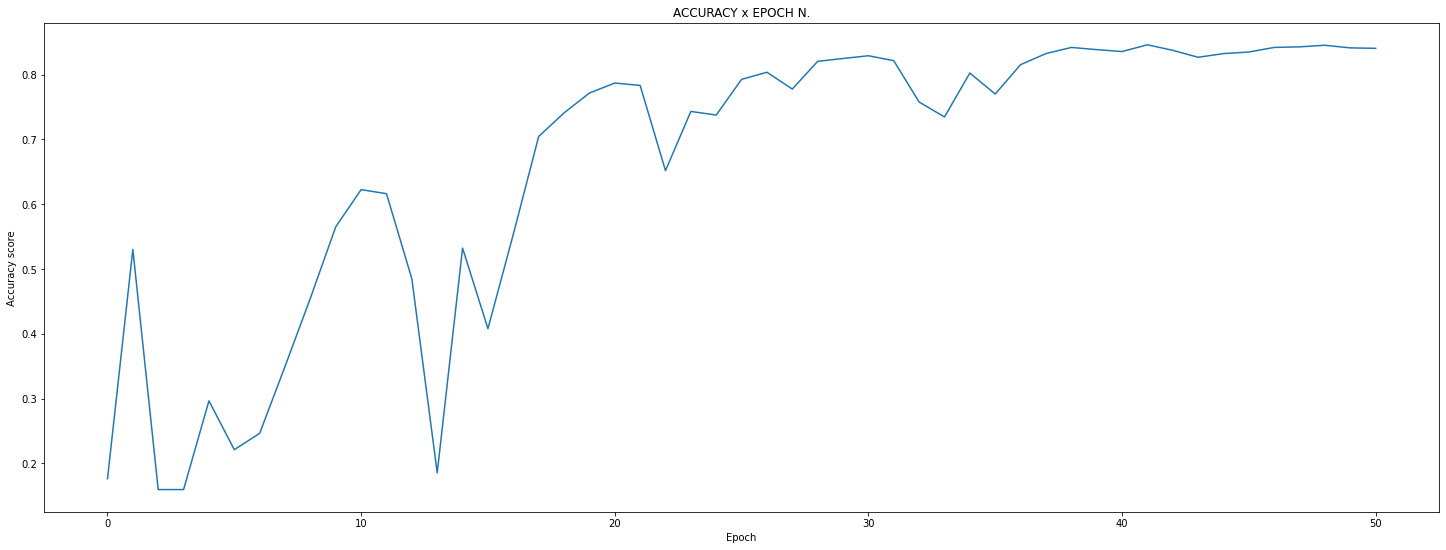

In [ ]:
plot_accs(hitory1)

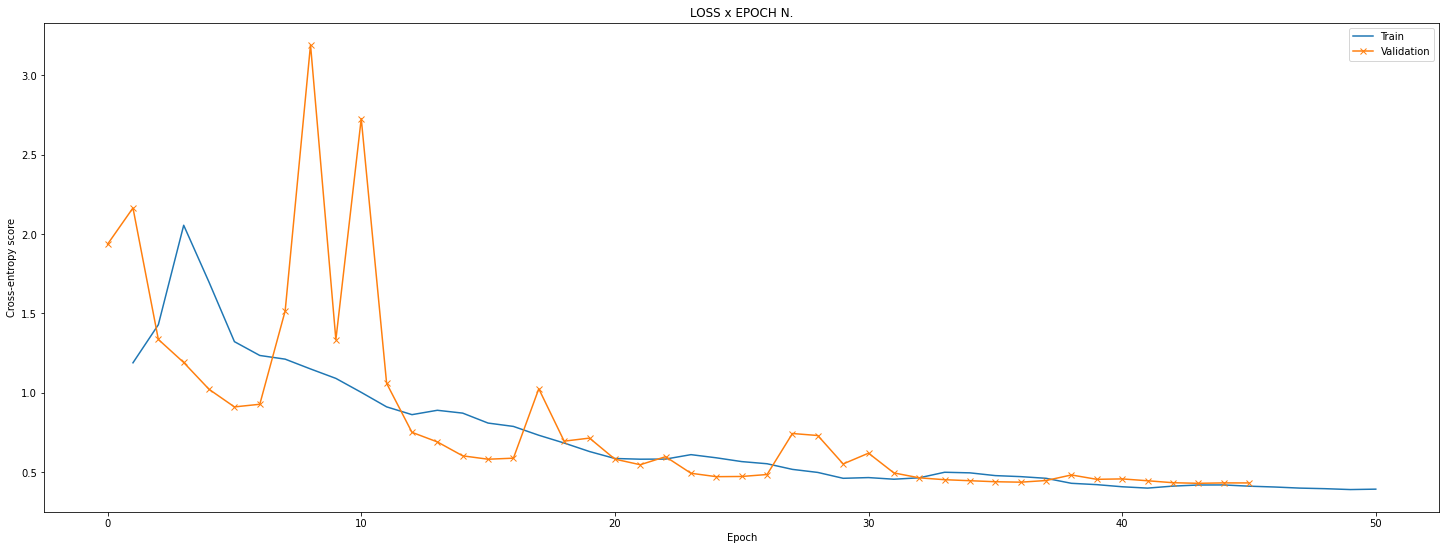

In [ ]:
plot_losses(hitory1)

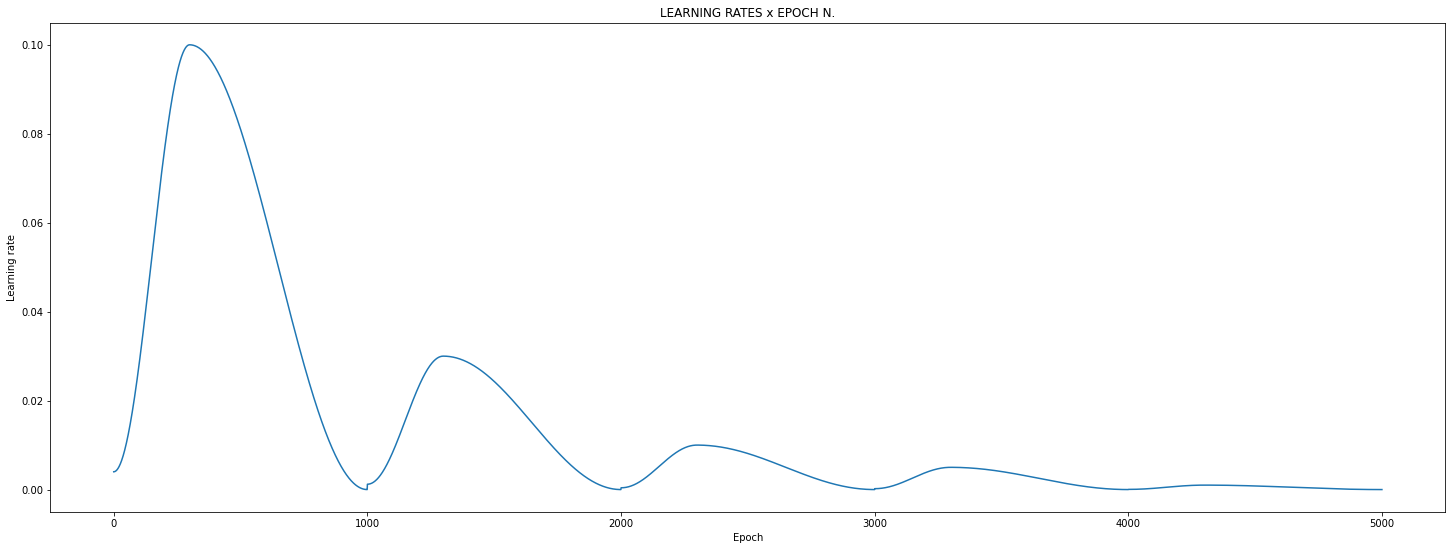

In [ ]:
plot_lrs(hitory1)

In [ ]:
torch.save(model1.state_dict(), 'intel_image_classification.pth')

In [ ]:
%cd '/content/drive/MyDrive/kaggle competitions/intel-image-classification'

/content/drive/MyDrive/kaggle competitions/intel-image-classification


In [ ]:
!cp '/content/intel_image_classification.pth' '/content/drive/MyDrive/kaggle competitions/intel-image-classification'